In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [84]:
# IMPORT DATASET
fundamentals = pd.read_csv('fundamentals_final.csv')
returns = pd.read_csv('crsp_final.csv')
rf = pd.read_csv('rf.csv')
link_table = pd.read_csv('linking_table.csv')

In [ ]:
# CLEAN FUNDAMENTALS
fundamentals = fundamentals.drop(columns={'indfmt', 'consol', 'popsrc', 'datafmt', 'curcd', 'costat',})
fundamentals = fundamentals[
    (fundamentals['fic'] == 'USA') & 
    (~fundamentals['sic'].between(6000, 6999)) &  
    (fundamentals['sic'] != 2834) &  
    (fundamentals['exchg'].between(11, 19))
]

 # FILL XRD
fundamentals = fundamentals[~(fundamentals['xrd'].isna() & fundamentals['revt'].isna())]
fundamentals['xrd'].fillna(0,inplace=True)

fundamentals = fundamentals.sort_values(by='datadate',ascending=True)
print(fundamentals)

In [ ]:
# TIME SHIFT - FUNDAMENTALS 

fundamentals['datadate'] = pd.to_datetime(fundamentals['datadate'])
fundamentals.rename(columns={'datadate': 'orig_datadate'}, inplace=True)
fundamentals['datadate_3m'] = fundamentals['orig_datadate'] + pd.Timedelta(days=90)
fundamentals['datadate_1y'] = fundamentals['orig_datadate'] + pd.DateOffset(years=1)
fundamentals.rename(columns={'datadate_1y': 'datadate'}, inplace=True)
print(fundamentals)

In [ ]:
missing = fundamentals.isnull().mean() * 100

print("Percentage of Missing Values in Compustat Data:")
print(missing)

missing_returns = returns.isnull().mean() * 100

print("Percentage of Missing Values in CRSP Data:")
print(missing_returns)

In [ ]:
# CLEAN RETURNS
returns = returns[
    (~returns['MthRet'].isna()) &  
    (returns['MthRet'].apply(lambda x: isinstance(x, (int, float)))) &  
    (returns['MthRet'] >= -100) &  
    (~returns['SICCD'].between(6000, 6999)) &  
    (returns['SICCD'] != 2834)  
]

print(returns)

In [ ]:
# CLEAN LINKING TABLE
returns['MthCalDt'] = pd.to_datetime(returns['MthCalDt'])
link_table['LINKDT'] = pd.to_datetime(link_table['LINKDT'], errors='coerce')
link_table['LINKENDDT'] = pd.to_datetime(link_table['LINKENDDT'], errors='coerce')
link_table

In [ ]:
# MERGE FUNDAMENTALS WITH LINKING TABLE
cstat_linked = pd.merge(fundamentals, link_table, left_on='gvkey', right_on='gvkey', how='inner')

# FILTER LINKING TABLE
cstat_linked = cstat_linked[
    (cstat_linked['LINKTYPE'].isin(['LC', 'LU', 'LS'])) &
    (cstat_linked['LINKDT'] <= cstat_linked['datadate']) &
    ((cstat_linked['LINKENDDT'] >= cstat_linked['datadate']) | cstat_linked['LINKENDDT'].isna())
]

# EXPAND COMPUSTAT TO COVER EVERY MONTH
cstat_expanded = cstat_linked.loc[cstat_linked.index.repeat(12)].reset_index(drop=True)
cstat_expanded['month'] = cstat_expanded.groupby(['gvkey', 'datadate']).cumcount() + 1
cstat_expanded['datadate'] = cstat_expanded.apply(lambda row: row['datadate'] + pd.DateOffset(months=row['month']-1), axis=1)
cstat_linked

In [ ]:
# CONVERT DATE TYPES
cstat_expanded['datadate'] = pd.to_datetime(cstat_expanded['datadate'], errors='coerce').dt.to_period('M')
returns['MthCalDt'] = pd.to_datetime(returns['MthCalDt'], errors='coerce').dt.to_period('M')

# MERGE COMPUSTAT WITH RETURNS
merged_data = pd.merge(
    cstat_expanded, 
    returns, 
    left_on=['LPERMNO', 'datadate'],
    right_on=['PERMNO', 'MthCalDt'], 
    how='inner'
)

merged_data[(merged_data['datadate'] >= '1980-01-01') & (merged_data['datadate'] < '2023-01-01')].groupby('datadate').size()
merged_data

In [92]:
crsp_compustat_clean = merged_data.sort_values(by=['datadate', 'LPERMNO'])

In [93]:
# CREATE BINARY R&D EXPENSE
crsp_compustat_clean['R&D'] = crsp_compustat_clean['xrd'].apply(lambda x: '1' if x > 0 else '0')
crsp_compustat_clean['R&D'] = crsp_compustat_clean['R&D'].astype(int)

# CREATE MARKET VALUE & SHIFT MARKET CAP
crsp_compustat_clean['marketcap_lagged'] = crsp_compustat_clean.groupby('LPERMNO')['MthCap'].shift(1)
crsp_compustat_clean['total_market_cap'] = crsp_compustat_clean.groupby('datadate')['marketcap_lagged'].transform('sum')

# DROP NA
crsp_compustat_clean = crsp_compustat_clean[~(crsp_compustat_clean['MthCap'].isna() | crsp_compustat_clean['MthRet'].isna())]
crsp_compustat_clean.isna().sum()

# CONVERT UNITS
crsp_compustat_clean['MthRet'] = crsp_compustat_clean['MthRet'] * 100

# DROP DUPLICATES
crsp_compustat_clean = crsp_compustat_clean.drop_duplicates(subset=['gvkey', 'datadate'])

In [94]:
crsp_compustat_clean

,gvkey,orig_datadate,fyear,tic_x,conm,revt,xrd,exchg,fic,sic,...,Ticker,PERMCO,SICCD,MthCalDt,MthPrc,MthCap,MthRet,R&D,marketcap_lagged,total_market_cap
1681,1803,1978-01-31,1977,DG.2,ASSOCIATED DRY GOODS CORP,1467.755,0.000,11.0,USA,5311,...,DG,22202,5311,1979-01,16.500,2.229975e+05,0.7634,0,NaN,0.000000e+00
1050,1139,1978-01-31,1977,ACTC.,ADVANCED CHEMICAL TECHNOLOGY,13.775,0.000,13.0,USA,3412,...,ACTC,54,3079,1979-01,1.375,1.794380e+03,10.0000,0,NaN,0.000000e+00
1609,1173,1978-01-31,1977,AIM.1,AEROSONIC CORP,5.730,0.400,12.0,USA,3812,...,ASON,376,3811,1979-01,6.000,1.068600e+04,-2.0408,1,NaN,0.000000e+00
857,6260,1978-01-31,1977,JWL.,JEWEL COS INC,3277.741,0.000,11.0,USA,5411,...,JWL,22369,5411,1979-01,20.250,2.250788e+05,0.6211,0,NaN,0.000000e+00
983,6307,1978-01-31,1977,SHLDQ,SEARS HOLDINGS CORP,10064.402,0.000,19.0,USA,5311,...,KM,21028,5331,1979-01,24.375,2.977211e+06,8.3333,0,NaN,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1887689,29962,2022-10-31,2022,LMNR,LIMONEIRA CO,184.605,0.000,14.0,USA,100,...,LMNR,53423,9999,2023-12,20.630,3.712162e+05,36.2171,0,2.735088e+05,3.614245e+10
1888833,10567,2022-12-31,2022,SIX,SIX FLAGS ENTERTAINMENT -OLD,1358.236,0.000,11.0,USA,7996,...,SIX,53440,7389,2023-12,25.080,2.095108e+06,0.7229,0,2.080071e+06,3.614245e+10
1888026,185138,2022-12-31,2022,VPG,VISHAY PRECISION GROUP INC,362.580,19.800,11.0,USA,3674,...,VPG,53443,3676,2023-12,34.070,4.262157e+05,11.7416,1,3.814299e+05,3.614245e+10
1886415,184259,2022-06-30,2022,SANW,S&W SEED CO,71.354,7.711,14.0,USA,100,...,SANW,53427,9999,2023-12,0.700,3.012730e+04,6.5449,1,2.827662e+04,3.614245e+10


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


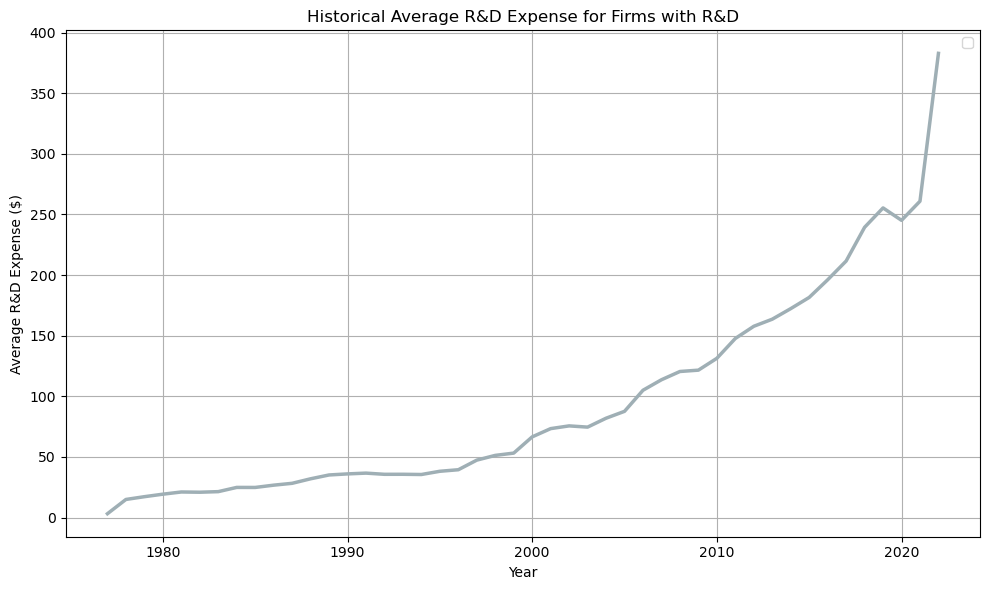

In [95]:
#PLOT 1
crsp_compustat_clean['orig_datadate'] = pd.to_datetime(crsp_compustat_clean['orig_datadate'])

rd_firms = crsp_compustat_clean[crsp_compustat_clean['R&D'] == 1]
average_rd_expense = rd_firms.groupby('fyear')['xrd'].mean()

plt.figure(figsize=(10, 6))
plt.plot(average_rd_expense.index, average_rd_expense.values, linestyle='-', linewidth=2.5, color='#9FAFB5')
plt.title('Historical Average R&D Expense for Firms with R&D')
plt.xlabel('Year')
plt.ylabel('Average R&D Expense ($)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

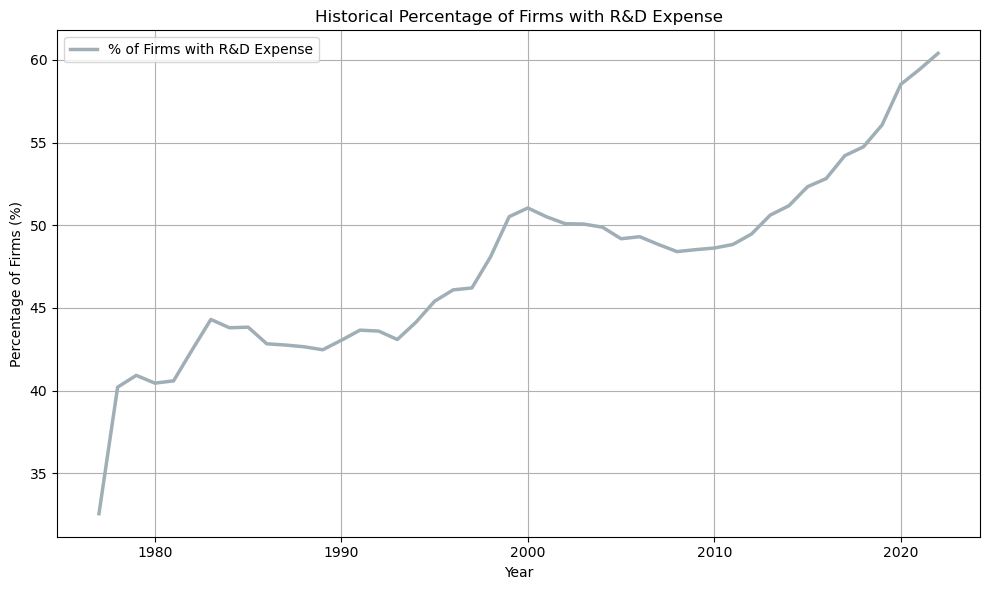

In [96]:
# PLOT 2
total_firms_by_year = crsp_compustat_clean.groupby('fyear')['R&D'].count()
firms_with_rd_by_year = crsp_compustat_clean[crsp_compustat_clean['R&D'] == 1].groupby('fyear')['R&D'].count()
percentage_rd_firms = (firms_with_rd_by_year / total_firms_by_year) * 100

plt.figure(figsize=(10, 6))
plt.plot(percentage_rd_firms.index, percentage_rd_firms.values, linestyle='-', color='#9FAFB5', linewidth=2.5, label='% of Firms with R&D Expense')
plt.title('Historical Percentage of Firms with R&D Expense')
plt.xlabel('Year')
plt.ylabel('Percentage of Firms (%)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


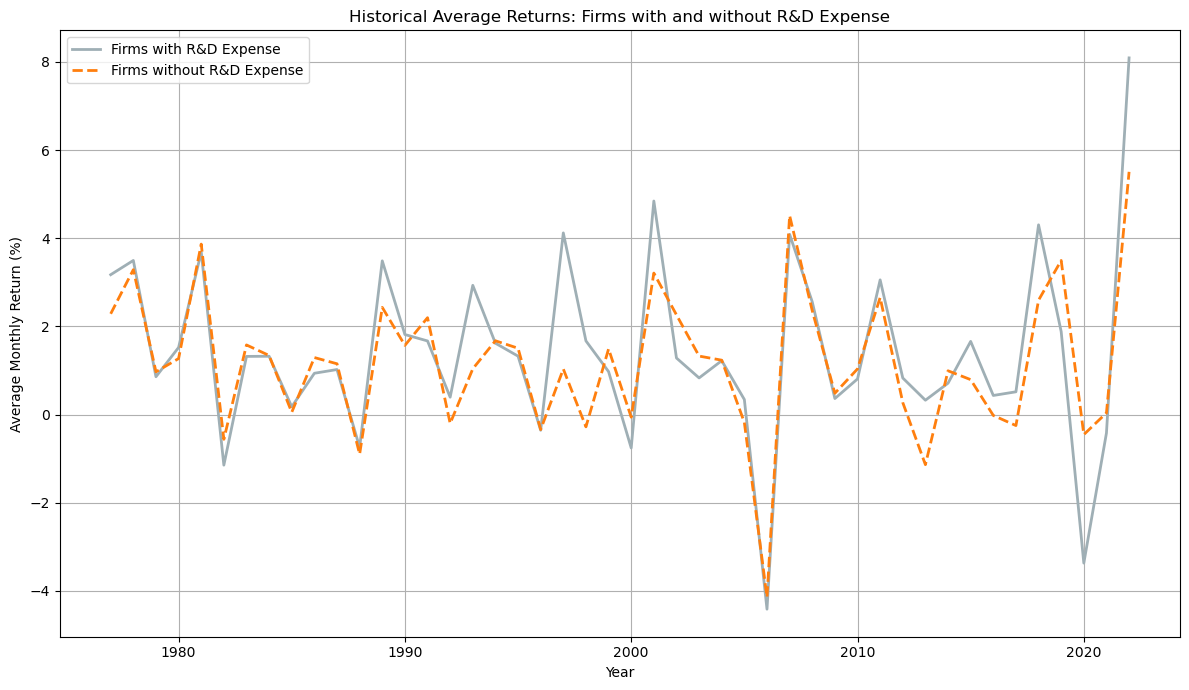

In [97]:
# PLOT 3
average_returns_with_rd = crsp_compustat_clean[crsp_compustat_clean['R&D'] == 1].groupby('fyear')['MthRet'].mean()
average_returns_without_rd = crsp_compustat_clean[crsp_compustat_clean['R&D'] == 0].groupby('fyear')['MthRet'].mean()

plt.figure(figsize=(12, 7))
plt.plot(average_returns_with_rd.index, average_returns_with_rd.values, linestyle='-', color='#9FAFB5', linewidth=2, label='Firms with R&D Expense')
plt.plot(average_returns_without_rd.index, average_returns_without_rd.values,  linestyle='--', color='#ff7f0e', linewidth=2, label='Firms without R&D Expense')
plt.title('Historical Average Returns: Firms with and without R&D Expense')
plt.xlabel('Year')
plt.ylabel('Average Monthly Return (%)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# CALCULATE PORTFOLIO RETURNS 

portfolio_results = []

for date, group in crsp_compustat_clean.groupby('MthCalDt'):
    rd = group[group['R&D'] == 1]
    no_rd = group[group['R&D'] == 0]

    # COMPUTE EQUAL WEIGHTED RETURNS
    ew_rd = rd['MthRet'].mean()
    ew_no_rd = no_rd['MthRet'].mean()

  # COMPUTE VALUE WEIGHTED RETURNS
    if not rd.empty:
        total_market_cap_rd = rd['marketcap_lagged'].sum()
        rd['weight'] = rd['marketcap_lagged'] / total_market_cap_rd
        vw_rd = (rd['weight'] * rd['MthRet']).sum()
    else:
        vw_rd = 0

    if not no_rd.empty:
        total_market_cap_no_rd = no_rd['marketcap_lagged'].sum()
        no_rd['weight'] = no_rd['marketcap_lagged'] / total_market_cap_no_rd
        vw_no_rd = (no_rd['weight'] * no_rd['MthRet']).sum()
    else:
        vw_no_rd = 0

    portfolio_results.append({
        'MthCalDt': date,
        'EW_R&D': ew_rd,
        'EW_No_R&D': ew_no_rd,
        'VW_R&D': vw_rd,
        'VW_No_R&D': vw_no_rd
    })

portfolios = pd.DataFrame(portfolio_results)
portfolios= portfolios[(portfolios['MthCalDt'] >= '1980-01')  & (portfolios['MthCalDt'] < '2023-01-01')]
portfolios = portfolios.sort_values(by='MthCalDt').reset_index(drop=True)
portfolios.to_csv("monthly_portfolio_results.csv", index=False)

print(portfolios)

In [99]:
portfolios.rename(columns={'index': 'MthCalDt'}, inplace=True) 

In [100]:
rf = pd.read_csv('rf.csv')

In [101]:
# CLEAN RF

rf['date'] = rf['date'].astype(str)
rf['MthCalDt'] = pd.to_datetime(rf['date'], format='%Y%m').dt.to_period('M')
rf.drop(columns=['date'], inplace=True)

In [102]:
monthly_rf = rf.groupby('MthCalDt')[['mktrf', 'rf']].mean().reset_index()

In [ ]:
# MERGE RF & MKTRF
merged_portfolios = portfolios.merge(monthly_rf, on='MthCalDt', how='left')
print(merged_portfolios)

In [107]:
cleaned_portfolios = merged_portfolios.dropna(subset=['mktrf'])
portfolio_columns = ['EW_R&D', 'EW_No_R&D', 'VW_R&D', 'VW_No_R&D']

# SUBTRACT RF
for col in portfolio_columns:
    cleaned_portfolios[col] = cleaned_portfolios[col] - cleaned_portfolios['rf']

print(cleaned_portfolios)

    MthCalDt     EW_R&D  EW_No_R&D     VW_R&D  VW_No_R&D  mktrf    rf
0    1980-01  10.431908   8.978622   7.262366   4.501426   5.51  0.80
1    1980-02  -2.123137  -1.228019   0.046828  -1.340966  -1.22  0.89
2    1980-03 -18.362567 -17.223363 -13.235452 -13.618746 -12.90  1.21
3    1980-04   2.978338   3.680551   2.152716   5.859737   3.97  1.26
4    1980-05   5.838379   6.507816   4.350215   5.899523   5.26  0.81
..       ...        ...        ...        ...        ...    ...   ...
511  2022-08   0.040274  -0.575201  -4.480356  -1.950086  -3.77  0.19
512  2022-09 -11.899367 -12.709131 -10.460470  -9.917896  -9.35  0.19
513  2022-10   4.683454  10.410370   6.287285   9.299307   7.83  0.23
514  2022-11  -0.518386   2.057760   3.988014   6.002390   4.61  0.29
515  2022-12  -6.046518  -8.161852  -7.404472  -5.398968  -6.41  0.33

[516 rows x 7 columns]


In [108]:
# REGRESSION 
portfolio_columns = ['EW_R&D', 'EW_No_R&D', 'VW_R&D', 'VW_No_R&D']
regression_results = []

for portfolio in portfolio_columns:
    data = cleaned_portfolios[[portfolio, 'mktrf']].apply(pd.to_numeric, errors='coerce').dropna()
    
    y = data[portfolio]  
    X = sm.add_constant(data['mktrf'])
    
    model = sm.OLS(y, X).fit()
    
    regression_results.append({
        'Portfolio': portfolio,
        'Alpha': model.params['const'],
        'Beta': model.params['mktrf'],
        'SE Alpha': model.bse['const'],
        'SE Beta': model.bse['mktrf'],
        'R-squared': model.rsquared,
        'Avg Return': y.mean()
    })
    
    print(f"Regression Results for {portfolio}:")
    print(model.summary())

results_df = pd.DataFrame(regression_results)
print(results_df)

Regression Results for EW_R&D:
                            OLS Regression Results                            
Dep. Variable:                 EW_R&D   R-squared:                       0.673
Model:                            OLS   Adj. R-squared:                  0.672
Method:                 Least Squares   F-statistic:                     1057.
Date:                Fri, 13 Dec 2024   Prob (F-statistic):          8.43e-127
Time:                        14:50:40   Log-Likelihood:                -1452.0
No. Observations:                 516   AIC:                             2908.
Df Residuals:                     514   BIC:                             2916.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0289

In [109]:
results_df['T-test Alpha'] = results_df['Alpha']/results_df['SE Alpha']
results_df['T-test Beta'] = results_df['Beta']/results_df['SE Beta']
results_df

,Portfolio,Alpha,Beta,SE Alpha,SE Beta,R-squared,Avg Return,T-test Alpha,T-test Beta
0,EW_R&D,0.028887,1.272363,0.179959,0.039134,0.672838,0.895351,0.160517,32.512856
1,EW_No_R&D,-0.011308,1.072594,0.138901,0.030206,0.710414,0.719116,-0.081413,35.509792
2,VW_R&D,-0.012421,1.081444,0.063020,0.013704,0.923752,0.724030,-0.197103,78.912362
3,VW_No_R&D,0.015655,0.915501,0.057623,0.012531,0.912165,0.639100,0.271680,73.060605
